# Text or Document Clustering

<sup>This notebook is a part of Natural Language Processing class at the University of Ljubljana, Faculty for computer and information science. Please contact [slavko.zitnik@fri.uni-lj.si](mailto:slavko.zitnik@fri.uni-lj.si) for any comments.</sub>

> Document clustering (or text clustering) is the application of cluster analysis to textual documents. It has applications in automatic document organization, topic extraction and fast information retrieval or filtering.

Clustering vs. Categorization:
* Categorization (supervised machine learning): To group objects into predetermined categories.
  Needs a representation of the objects, a similarity measure and a training set.
* Clustering (unsupervised machine learning): To divide a set of objects into clusters (parts of the set) so that objects in the same cluster are similar to each other, and/or objects in different clusters are dissimilar. Needs a representation of the objects and a similarity measure.

Document clustering involves the use of descriptors and descriptor extraction. Descriptors are sets of words that describe the contents within the cluster. Document clustering is generally considered to be a centralized process. Examples of document clustering include web document clustering for search users.

In general, there are two common algorithms. The first one is the hierarchical based algorithm, which includes single link, complete linkage, group average and Ward's method. By aggregating or dividing, documents can be clustered into hierarchical structure, which is suitable for browsing. However, such an algorithm usually suffers from efficiency problems. The other algorithm is developed using the K-means algorithm and its variants. Generally hierarchical algorithms produce more in-depth information for detailed analyses, while algorithms based around variants of the K-means algorithm are more efficient and provide sufficient information for most purposes.

The two types of algorithms:
* Partitioning algorithms
    1. Initial partition, for example: pick k documents at random as first cluster centroids.
    2. Put each document in the most similar cluster.
    3. Calculate new cluster centroids.
    4. Repeat 2 and 3 until some condition is fulfilled.
* Hierarchical algorithms
    1. Make one cluster for each document.
    2. Join the most similar pair into one cluster. 
    3. Repeat 2 until some condition is fulfilled.

***

There exist many tools to perform document clustering. One of them is [Ontogen](http://ontogen.ijs.si/), which automatically groups similar documents and visualizes them.

Below we will try to perform document clustering using Python. For the task we will use IMDB data - genres, titles and synopses for 100 movies. Example used by Brandon Rose.

In [39]:
import pandas as pd
import nltk
import re

# Import data
movies = pd.read_csv("movies_data.txt", sep='\t')
movies.head()

,Genres,Title,Synopses
0,"Crime,Drama",The Godfather,"On the day of his only daughter's wedding, Vit..."
1,"Crime,Drama",The Shawshank Redemption,"In 1947, banker Andy Dufresne is convicted of ..."
2,"Biography,Drama,History",Schindler's List,"In 1939, the Germans move Polish Jews into the..."
3,"Biography,Drama,Sport",Raging Bull,"In a brief scene in 1964, an aging, overweight..."
4,"Drama,Romance,War",Casablanca,It is early December 1941. American expatriate...


In [40]:
genres = movies["Genres"].tolist()
titles = movies["Title"].tolist()
synopses = movies["Synopses"].tolist()

print("First 10 movies in a dataset '{}.'".format(movies["Title"].tolist()[:10]))

First 10 movies in a dataset '['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca', "One Flew Over the Cuckoo's Nest", 'Gone with the Wind', 'Citizen Kane', 'The Wizard of Oz', 'Titanic'].'


## Preprocessing

Below we define two functions that:

* tokenize and also stem each token
* tokenize each token only

We use both these functions to create a dictionary as we will use stems for the clustering algorithm. We will need to convert stems back to their full words for the better representation.

In [41]:
# Load SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below we use the preprocessing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

Using these two, we create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc.

In [42]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

# Create a pandas DataFrame
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

print("There are '{}' items in our data frame.".format(str(vocab_frame.shape[0])))
print("Data frame contents: \n{}".format(vocab_frame.head(10)))

There are '164192' items in our data frame.
Data frame contents: 
             words
on              on
the            the
day            day
of              of
his            his
onli          only
daughter  daughter
's              's
wed        wedding
vito          vito


## TF-IDF and document similarity

Now we define a term frequency-inverse document frequency (TF-IDF) vectorizer parameters and then convert the synopses list into a TF-IDF matrix.

![tfidf.png](tfidf.png)

The parameters description:

* max_df: The maximum frequency within the documents a given feature can have to be used in the TF-IDF matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses).
* min_idf: This could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here we pass 0.2; the term must be in at least 20% of the document.
* ngram_range: This means we will look at unigrams, bigrams and trigrams. [More about ngrams](https://en.wikipedia.org/wiki/N-gram).

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
                        max_df=0.8, 
                        max_features=200000,
                        min_df=0.2, 
                        stop_words='english', 
                        use_idf=True, 
                        tokenizer=tokenize_and_stem, 
                        ngram_range=(1,3))

# Fit the vectorizer to synopses texts
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) 

print("TF-IDF matrix shape: {}".format(tfidf_matrix.shape))

/home/slavkoz/anaconda3/envs/nlp-course-fri/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 3.29 s, sys: 3.93 ms, total: 3.29 s
Wall time: 3.29 s
TF-IDF matrix shape: (100, 218)


Now we can extract terms for the features and calculate distances between documents.

Terms is just a list of the features used in the TF-IDF matrix (vocabulary).

Dist is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the TF-IDF matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.

In [44]:
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering

Now the fun part begins ... 

K-means initializes with a pre-determined number of clusters (we choose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [45]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

# Perform clustering
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

CPU times: user 52.4 ms, sys: 10 µs, total: 52.4 ms
Wall time: 51.6 ms
Clusters: [4, 3, 2, 1, 4, 4, 4, 4, 4, 4, 2, 4, 3, 0, 0, 3, 4, 4, 3, 4, 4, 0, 0, 3, 2, 1, 4, 4, 0, 2, 4, 2, 0, 2, 2, 2, 2, 4, 2, 1, 4, 1, 4, 4, 4, 4, 4, 4, 2, 2, 4, 1, 2, 4, 3, 2, 0, 2, 4, 3, 4, 2, 2, 0, 1, 4, 4, 0, 1, 4, 4, 1, 1, 1, 1, 1, 0, 4, 0, 0, 1, 0, 0, 0, 4, 1, 0, 2, 2, 2, 3, 1, 0, 4, 0, 0, 3, 3, 0, 4]


We can use joblib.dump to pickle the model (save it and load it later from disk), once it has converged and to reload the model/reassign the labels as the clusters.

In [46]:
import joblib

# Uncomment the below line to save your model 
#joblib.dump(km,  'doc_cluster.pkl')

# Uncomment the below line to load your saved model 
#km = joblib.load('doc_cluster.pkl')
#clusters = km.labels_.tolist()
print("Clusters: {}".format(clusters))

Clusters: [4, 3, 2, 1, 4, 4, 4, 4, 4, 4, 2, 4, 3, 0, 0, 3, 4, 4, 3, 4, 4, 0, 0, 3, 2, 1, 4, 4, 0, 2, 4, 2, 0, 2, 2, 2, 2, 4, 2, 1, 4, 1, 4, 4, 4, 4, 4, 4, 2, 2, 4, 1, 2, 4, 3, 2, 0, 2, 4, 3, 4, 2, 2, 0, 1, 4, 4, 0, 1, 4, 4, 1, 1, 1, 1, 1, 0, 4, 0, 0, 1, 0, 0, 0, 4, 1, 0, 2, 2, 2, 3, 1, 0, 4, 0, 0, 3, 3, 0, 4]


Now we create a dictionary of titles, the synopsis, the cluster assignment, and the genre.

In [47]:
films = { "title": titles, "synopsis": synopses, "cluster": clusters, "genre": genres }
frame = pd.DataFrame(films, index = [clusters] , columns = ["title", "cluster", "genre"])

print("Number of movies per cluster: \n{}".format(frame["cluster"].value_counts()))

Number of movies per cluster: 
4    35
2    20
0    20
1    15
3    10
Name: cluster, dtype: int64


Now perform indexing and sorting on each cluster to identify which are the top n (n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [48]:
print("Top terms per cluster:\n")

# Sort cluster centers by proximity to centroid.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

# Helper function
def getClusterWords(cluster, n=6):
    words = []
    for ind in order_centroids[cluster, :n]: # Print 6 words per cluster
        # old pandas version
        #words.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
        words.append(vocab_frame.loc[terms[ind].split(' '),].values.tolist()[0][0])
    return ", ".join(words)

for i in range(num_clusters):
    print("Cluster {} words: {}".format(i, getClusterWords(i)))
    
    print("Cluster {} titles:".format(i), end='')
    # old pandas version
    #for title in frame.ix[i]['title'].values.tolist():

    for title in frame[frame["cluster"]==i]["title"].values.tolist():
        print(" {},".format(title), end='')
    print("\n")

Top terms per cluster:

Cluster 0 words: drives, shoots, car, man, killed, train
Cluster 0 titles: Sunset Blvd., Vertigo, 2001: A Space Odyssey, The Silence of the Lambs, 12 Angry Men, Gandhi, High Noon, The French Connection, A Place in the Sun, Fargo, The Grapes of Wrath, Shane, Close Encounters of the Third Kind, Network, Nashville, Pulp Fiction, Taxi Driver, Double Indemnity, Rebel Without a Cause, North by Northwest,

Cluster 1 words: john, relationship, film, love, new, fight
Cluster 1 titles: Raging Bull, Singin' in the Rain, Rocky, The Philadelphia Story, The Good, the Bad and the Ugly, City Lights, Midnight Cowboy, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Tootsie, The Green Mile, American Graffiti, A Clockwork Orange,

Cluster 2 words: soldier, army, killed, war, command, orders
Cluster 2 titles: Schindler's List, Lawrence of Arabia, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The

## Visualizing the clusters

First we need to convert the dist matrix into a 2-dimensional array using multidimensional scaling. We use an MDS algorithm. Another option would be to use principal component analysis method.

In [49]:
from sklearn.manifold import MDS

# Parameter "precomputed" because we provide a distance matrix.
# Parameter "random_state" so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# Shape of the result will be (n_components, n_samples).
pos = mds.fit_transform(dist)  

xs, ys = pos[:, 0], pos[:, 1]

Below we visualize the document clustering output using matplotlib and [mpld3](https://mpld3.github.io/) (a matplotlib wrapper for [D3.js](http://d3js.org/) library).

In [50]:
# Define colors for clusters.
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

# Define cluster names
cluster_names = dict([(i, getClusterWords(i, 3)) for i in range(5)])

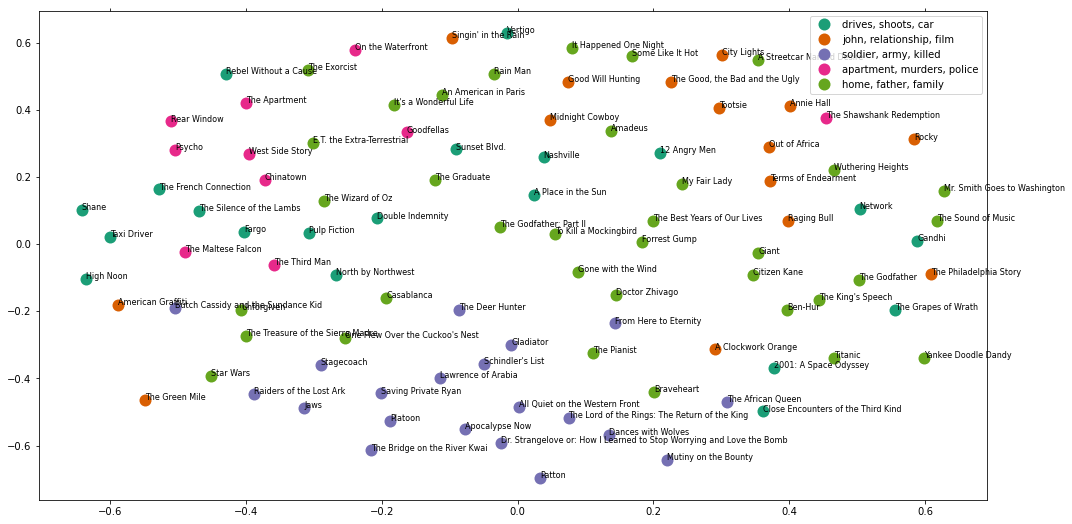

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Enable to draw plot inline.
%matplotlib inline

# Create a data frame that has the result of the MDS plus the cluster numbers and titles.
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# Group by cluster.
groups = df.groupby('label')


# Set up plot.
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# Iterate through groups to layer the plot.
# Note that we use the cluster_name and cluster_color dicts with the 'name' 
# lookup to return the appropriate color/label.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# Add label in x,y position with the label as the film title.
for i in range(len(df)):
    # old pandas:
    #ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8) 
    ax.text(df.loc[df.index[i], 'x'], df.loc[df.index[i], 'y'], df.loc[df.index[i], 'title'], size=8)  

# Uncomment the below to show or save the plot.
plt.show()                                       #show the plot
#plt.savefig('clusters_small_noaxes.png', dpi=200) # save the plot as an image 

plt.close()

OPTIONAL: Animated JS-based visualization (do not worry about the implementation, for more information, check mpld3 documentation)

In [52]:
import mpld3

# Define custom toolbar location.
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}
        
# Create a data frame that has the result of the MDS plus the cluster numbers and titles.
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# Group by cluster.
groups = df.groupby('label')

# Define custom css to format the font and to remove the axis labeling.
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# Iterate through groups to layer the plot.
# Note that I use the cluster_name and cluster_color dicts with the 'name' 
# lookup to return the appropriate color/label.
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    # Set tooltip using points, labels and the already defined 'css'.
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    # Connect tooltip to fig.
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    # Set tick marks as blank.
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    # Set axis as blank.
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) # show legend with only one dot

# Uncomment  accordingly to show the plot or save it to an html file.
mpld3.display() # show the plot
# OR
#clusterHTML = open("clusters.html", "w") # save as an HTML file
#clusterHTML.writelines(mpld3.fig_to_html(fig))
#clusterHTML.close()

## Hierarchical document clustering

Now try another clustering algorithm. Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. We used the precomputed cosine distance matrix (dist) to calculate a linkage_matrix, from which we then plot a dendrogram.

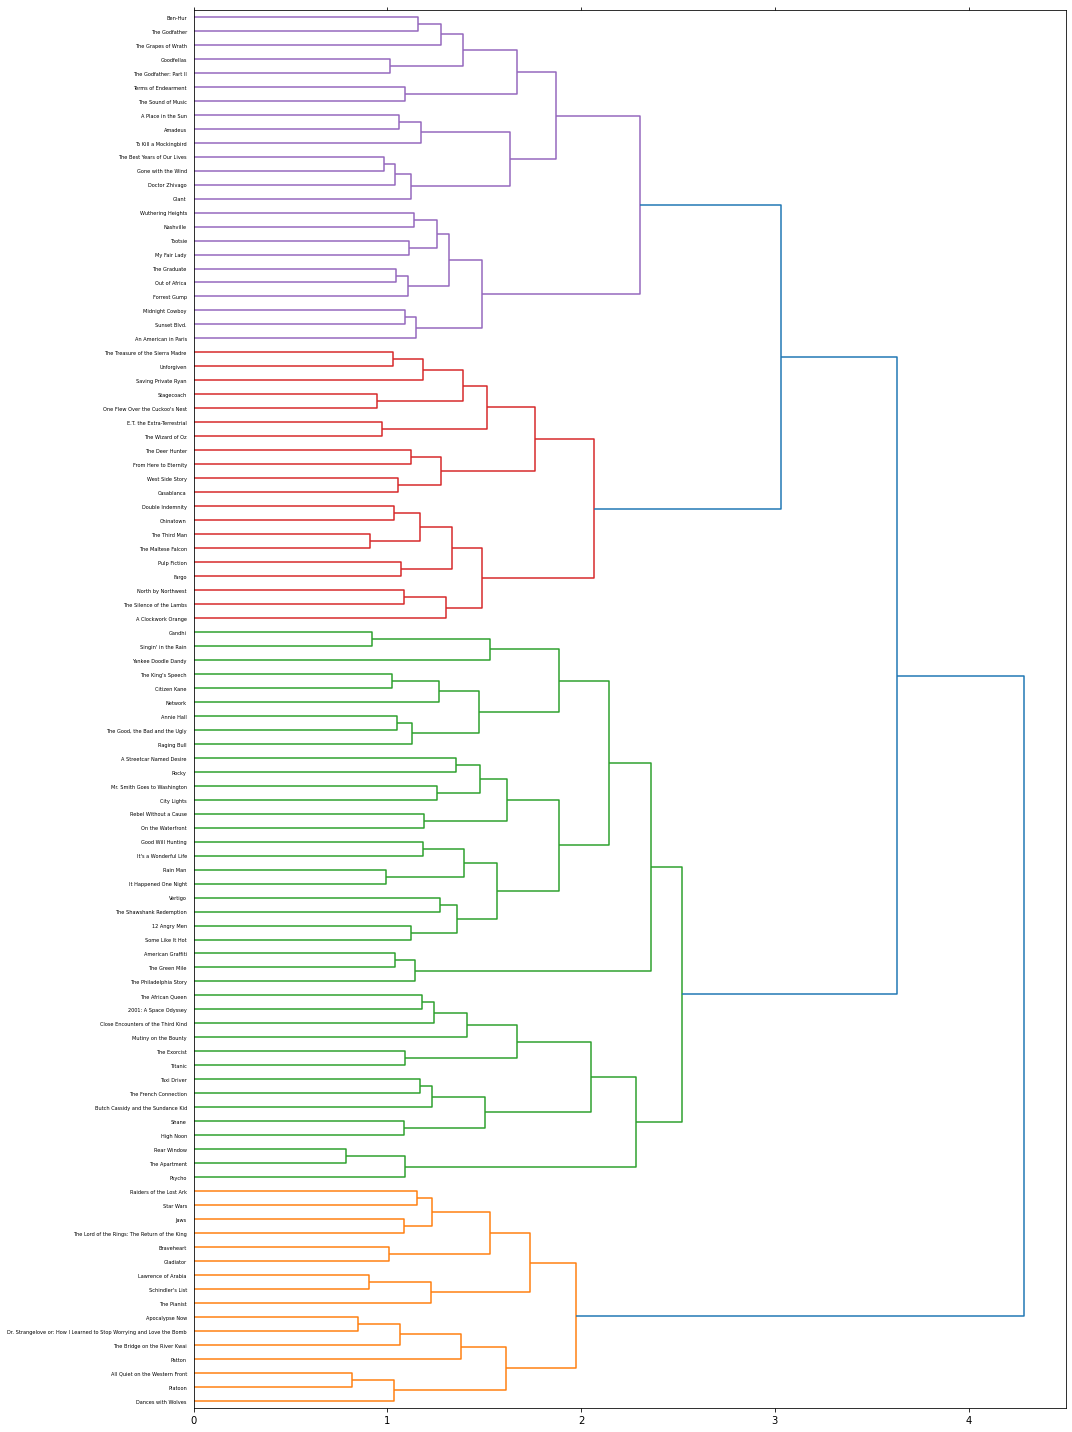

In [53]:
from scipy.cluster.hierarchy import ward, dendrogram

# Define the linkage_matrix using ward clustering pre-computed distances.
linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
plt.close()

## Exercises

* Try changing preprocessing techniques, TF-IDF parameters and observe differences.
* Use PCA (see [sci-kit learn docs](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) instead MDS.
* Try a different hierarchical agglomerative clustering. Check [SciPy documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/cluster.hierarchy.html) for possibilities or provide your own linkage matrix.

## References

* Notebook is an adaptation by [http://brandonrose.org/clustering](http://brandonrose.org/clustering).